In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,create_map, lit
from itertools import chain
import numpy as np
import pandas as pd
import subprocess

In [2]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Image
init_notebook_mode(connected=True)

In [3]:
spark = SparkSession.builder.appName('practice').getOrCreate()

In [4]:
prqt_loc = '../../../../datasets/ess/parquet/'

In [5]:
p = subprocess.Popen(f'ls {prqt_loc}', shell=True, stdout=subprocess.PIPE)
ret = p.communicate()
print('Exit code: {}\nOutput:\n\n{}'.format(p.returncode, ret[0].decode('utf-8')))

Exit code: 0
Output:

ns_ESS1_180115.parquet
ns_ESS2_180115.parquet
ns_ESS3_180115.parquet
ns_ESS4_190213.parquet
ns_ESS5_180115.parquet
ns_ESS6_180115.parquet
ns_ESS7_180115.parquet
ns_ESS8_190213.parquet



In [6]:
parquets = [ pqt for pqt in ret[0].decode('utf-8').split('\n') if pqt.find('.parquet') > 0 ]

In [7]:
df = spark.read.parquet(f"{prqt_loc}*.parquet")

In [8]:
len( df.columns )

1496

In [9]:
df.count()

380384

In [10]:
df.select('cntry','happy','essround').sample(0.00001).toPandas()

,cntry,happy,essround
0,LV,2.0,4
1,CZ,9.0,5
2,LT,6.0,5
3,IT,8.0,8
4,AT,10.0,3


In [11]:
ess_year = {1:2002,2:2004,3:2006,4:2008,5:2010,6:2012,7:2014,8:2016}

In [12]:
mapping_expr = create_map([lit(x) for x in chain(*ess_year.items())])

In [13]:
df2 = df.select('cntry','happy','essround').withColumn('essround', mapping_expr[df['essround']])

In [14]:
df_temp = df2.select('cntry','happy','essround').filter(col('happy') < 11).groupBy('cntry','essround').mean('happy').sort(col('essround').desc()).toPandas()

In [15]:
df_temp.cntry.unique()

array(['FI', 'CZ', 'BE', 'LT', 'ES', 'NO', 'NL', 'PL', 'CH', 'IT', 'GB',
       'DE', 'IS', 'IE', 'SI', 'HU', 'AT', 'RU', 'PT', 'IL', 'SE', 'FR',
       'EE', 'DK', 'BG', 'SK', 'CY', 'UA', 'HR', 'GR', 'TR', 'LV', 'RO',
       'LU'], dtype=object)

In [16]:
cntry_filter = ['HU','RO','SK','AT','PL','CZ','DE']

In [17]:
fig = go.Figure({
    "data": [ go.Scatter( x= df_temp[df_temp.cntry == cntry]['essround'],
                     y= df_temp[df_temp.cntry == cntry]['avg(happy)'],
                     name=cntry ) for cntry in cntry_filter ],
    "layout": go.Layout(title="Avarage happiness 2002 - 2016 )")
})

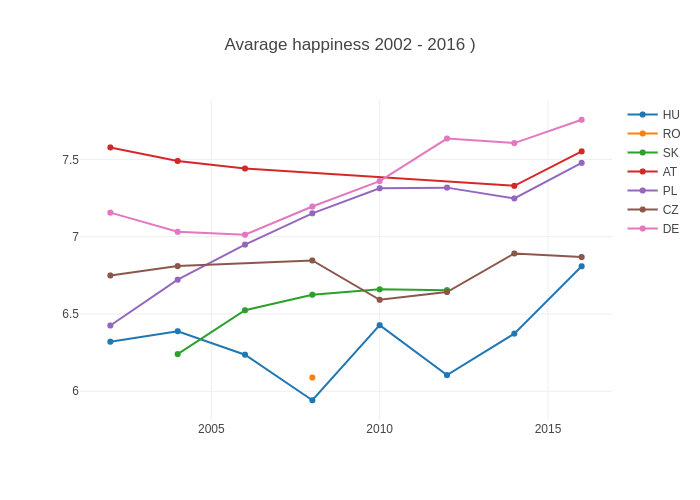

In [18]:
Image(plotly.io.to_image(fig))

In [19]:
df_temp = df2.filter(col('cntry') == 'HU').filter(col('happy') < 11).select('happy','essround').groupBy('essround').mean('happy').sort(col('essround').desc()).toPandas()
fig = go.Figure({
    "data": [go.Scatter(x=df_temp['essround'], y=df_temp['avg(happy)'])],
    "layout": go.Layout(title="Hungary (avarage happiness 2002 - 2016 )")
})

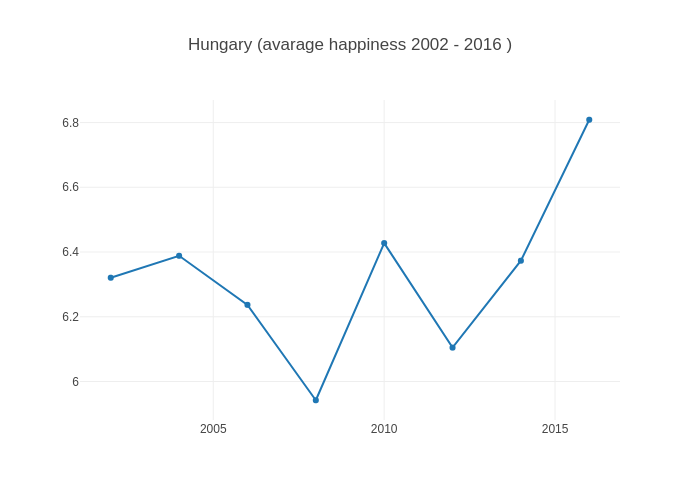

In [20]:
Image(plotly.io.to_image(fig))

In [21]:
df2 = df.select('cntry','happy','essround','agea').withColumn('essround', mapping_expr[df['essround']]).filter(col('cntry') == 'HU').filter(col('agea') < 999)

In [22]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, max as _max

In [23]:
df2.select(_mean(col('agea')),_stddev('agea'),_max('agea')).show()

+-----------------+-----------------+---------+
|        avg(agea)|stddev_samp(agea)|max(agea)|
+-----------------+-----------------+---------+
|48.34431229033242|18.52969731209441|     95.0|
+-----------------+-----------------+---------+



In [24]:
df_age1 = df2.filter(col('happy') < 11). \
filter(col('agea') <= 25). \
select('happy','essround'). \
groupBy('essround').mean('happy'). \
sort(col('essround').desc()).toPandas()

In [25]:
df_age2 = df2.filter(col('happy') < 11).filter(col('agea') > 25).filter(col('agea') <= 45).select('happy','essround').groupBy('essround').mean('happy').sort(col('essround').desc()).toPandas()
df_age3 = df2.filter(col('happy') < 11).filter(col('agea') > 45).filter(col('agea') <= 65).select('happy','essround').groupBy('essround').mean('happy').sort(col('essround').desc()).toPandas()
df_age4 = df2.filter(col('happy') < 11).filter(col('agea') > 65).filter(col('agea') <= 85).select('happy','essround').groupBy('essround').mean('happy').sort(col('essround').desc()).toPandas()
df_age5 = df2.filter(col('happy') < 11).filter(col('agea') > 85).select('happy','essround').groupBy('essround').mean('happy'). sort(col('essround').desc()).toPandas()

In [26]:
fig = go.Figure({
    "data": [ go.Scatter( x= df_age1['essround'], y= df_age1['avg(happy)'], name='-25' ), 
              go.Scatter( x= df_age2['essround'], y= df_age2['avg(happy)'], name='26-45' ),
              go.Scatter( x= df_age3['essround'], y= df_age3['avg(happy)'], name='46-65' ),
              go.Scatter( x= df_age4['essround'], y= df_age4['avg(happy)'], name='66-85' ),
              go.Scatter( x= df_age5['essround'], y= df_age5['avg(happy)'], name='85-' )
            ],
    "layout": go.Layout(title="Avarage happiness 2002 - 2016 )")
})

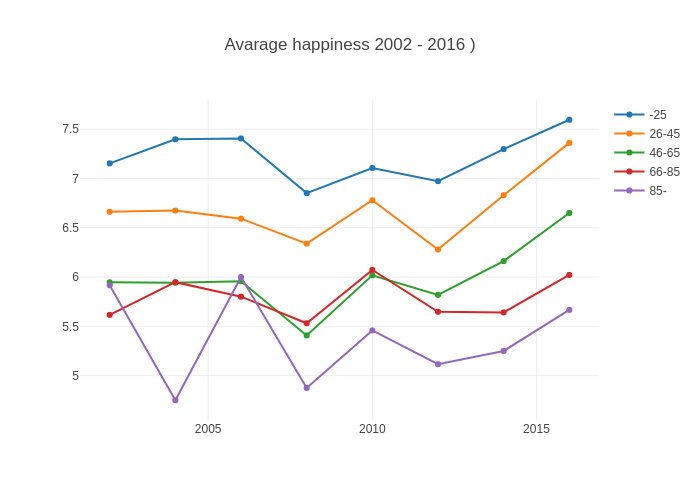

In [27]:
Image(plotly.io.to_image(fig))